## Setup the Env


In [1]:
import os
import sys

import sagemaker
from sagemaker import get_execution_role

# Add the parent directory to the sys.path
sys.path.insert(0, os.path.abspath(".."))

# Define IAM role
role = get_execution_role()
role

# Establish S3 bucket connection
import boto3

s3 = boto3.client("s3")
bucket = "capstone-bucket-4-friends"

# Take a look at current dir
print(os.getcwd())

from file_utilities import s3_download

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml
/home/sagemaker-user/capstone-2024-summer/src/shuo


## Import Package

In [2]:
!pip install seaborn
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import warnings
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
import joblib
import time
import logging
import torch.distributions as dist
from sklearn.preprocessing import StandardScaler


warnings.filterwarnings("ignore")
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)


In [3]:
# pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113


In [4]:
torch.cuda.is_available()


True

In [5]:
import torch
import torch.nn as nn

# Check if CUDA is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available. Using GPU.")
else:
    device = torch.device("cpu")
    print("CUDA is not available. Using CPU.")

# Example model
model = nn.Linear(10, 2)

# Move model to the device (GPU if available)
model.to(device)

# Example data
x = torch.randn(1, 10).to(device)
output = model(x)
print(output)


CUDA is available. Using GPU.
tensor([[-1.1584,  0.6653]], device='cuda:0', grad_fn=<AddmmBackward0>)


In [6]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

## Load Data

In [7]:
# reload_path = s3_download("CRSP/crsp_2018-2023_clean_3.parquet")
# reload_path

In [8]:
os.getcwd()

'/home/sagemaker-user/capstone-2024-summer/src/shuo'

In [9]:
!pwd

/home/sagemaker-user/capstone-2024-summer/src/shuo


In [10]:
df = pd.read_parquet("../../data/crsp_2018-2023_clean_3.parquet")

In [11]:
df

date permno_id ncusip_id  cusip_id ticker share_code  \
9263    2018-01-02     10104  68389X10  68389X10   ORCL       11.0   
9264    2018-01-03     10104  68389X10  68389X10   ORCL       11.0   
9265    2018-01-04     10104  68389X10  68389X10   ORCL       11.0   
9266    2018-01-05     10104  68389X10  68389X10   ORCL       11.0   
9267    2018-01-08     10104  68389X10  68389X10   ORCL       11.0   
...            ...       ...       ...       ...    ...        ...   
7656951 2023-12-22     93436  88160R10  88160R10   TSLA       11.0   
7656952 2023-12-26     93436  88160R10  88160R10   TSLA       11.0   
7656953 2023-12-27     93436  88160R10  88160R10   TSLA       11.0   
7656954 2023-12-28     93436  88160R10  88160R10   TSLA       11.0   
7656955 2023-12-29     93436  88160R10  88160R10   TSLA       11.0   

        share_code_type share_code_detail exchange_code company_name  \
9263                  1                 1             1  ORACLE CORP   
9264                  1                 1             1  ORACLE CORP   
9265                  1                 1             1  ORACLE CORP   
9266                  1                 1             1  ORACLE CORP   
9267                  1                 1             1  ORACLE CORP   
...                 ...               ...           ...          ...   
7656951               1                 1             3    TESLA INC   
7656952               1                 1             3    TESLA INC   
7656953               1                 1             3    TESLA INC   
7656954               1                 1             3    TESLA INC   
7656955               1                 1             3    TESLA INC   

        primary_exchange trading_status security_status     naics  \
9263                   N              A               R  511210.0   
9264                   N              A               R  511210.0   
9265                   N              A               R  511210.0   
9266                   N              A               R  511210.0   
9267                   N              A               R  511210.0   
...                  ...            ...             ...       ...   
7656951                Q              A               R  336110.0   
7656952                Q              A               R  336110.0   
7656953                Q              A               R  336110.0   
7656954                Q              A               R  336110.0   
7656955                Q              A               R  336110.0   

        naics_sector naics_sector_name naics_secondary  ask_or_high_price  \
9263              51       Information          1210.0            47.8011   
9264              51       Information          1210.0            48.0700   
9265              51       Information          1210.0            48.1900   
9266              51       Information          1210.0            48.6300   
9267              51       Information          1210.0            49.0700   
...              ...               ...             ...                ...   
7656951           33     Manufacturing          6110.0           258.2200   
7656952           33     Manufacturing          6110.0           257.9700   
7656953           33     Manufacturing          6110.0           263.3400   
7656954           33     Manufacturing          6110.0           265.1300   
7656955           33     Manufacturing          6110.0           255.1900   

         ask_price  bid_or_low_price  bid_price  open_price  close_price  \
9263      46.63000          46.17000   46.62000    47.57000     46.63000   
9264      47.71000          47.44000   47.70000    47.53000     47.71000   
9265      48.18000          47.71500   48.17000    47.99000     48.18000   
9266      48.45000          48.28000   48.44000    48.42000     48.47000   
9267      48.99000          47.94000   48.98000    48.30000     48.98000   
...            ...               ...        ...         ...          ...   
7656951  252.53999    

In [12]:
df.dtypes

date                              datetime64[ns]
permno_id                                 object
ncusip_id                                 object
cusip_id                                  object
ticker                                    object
share_code                                object
share_code_type                           object
share_code_detail                         object
exchange_code                             object
company_name                              object
primary_exchange                          object
trading_status                            object
security_status                           object
naics                                     object
naics_sector                              object
naics_sector_name                         object
naics_secondary                           object
ask_or_high_price                        float64
ask_price                                float64
bid_or_low_price                         float64
bid_price           

## Feature Engineering

### Feature Selection

In [13]:
data = df[
    [
        "date",
        "permno_id",
        # "naics",
        "log_return",
        "abs_log_return",
        "sector_weighted_avg_log_return",
        "sector_simple_avg_log_return",
        "weighted_avg_log_return",
        "simple_avg_log_return",
        "log_return_7",
        "abs_log_return_7",
        "log_return_14",
        "abs_log_return_14",
        "log_return_28",
        "abs_log_return_28",
        "volatility_7",
        "volatility_14",
        "volatility_28",
    ]
].copy()
data

date permno_id  log_return  abs_log_return  \
9263    2018-01-02     10104   -0.013843        0.013843   
9264    2018-01-03     10104    0.022897        0.022897   
9265    2018-01-04     10104    0.009803        0.009803   
9266    2018-01-05     10104    0.006001        0.006001   
9267    2018-01-08     10104    0.010467        0.010467   
...            ...       ...         ...             ...   
7656951 2023-12-22     93436   -0.007731        0.007731   
7656952 2023-12-26     93436    0.015988        0.015988   
7656953 2023-12-27     93436    0.018647        0.018647   
7656954 2023-12-28     93436   -0.032104        0.032104   
7656955 2023-12-29     93436   -0.018738        0.018738   

         sector_weighted_avg_log_return  sector_simple_avg_log_return  \
9263                           0.000000                      0.000000   
9264                           0.006404                      0.004872   
9265                           0.004048                      0.000960   
9266                           0.009581                      0.006722   
9267                           0.002142                      0.005354   
...                                 ...                           ...   
7656951                        0.000259                      0.007069   
7656952                        0.007335                      0.009616   
7656953                        0.002344                      0.001393   
7656954                       -0.001451                     -0.000214   
7656955                       -0.005400                     -0.005035   

         weighted_avg_log_return  simple_avg_log_return  log_return_7  \
9263                    0.000000               0.000000      0.309424   
9264                    0.005904               0.007983      0.234088   
9265                    0.004021               0.000852      0.183199   
9266                    0.006193               0.002919      0.230474   
9267                    0.001829               0.005828      0.161223   
...                          ...                    ...           ...   
7656951                 0.002502               0.004469      0.000000   
7656952                 0.005189               0.003873      0.000000   
7656953                 0.001653               0.001163      0.000000   
7656954                -0.000266               0.002184      0.000000   
7656955                -0.004121              -0.004627      0.000000   

         abs_log_return_7  log_return_14  abs_log_return_14  log_return_28  \
9263             0.309424       0.131071           0.131071       0.011619   
9264             0.234088       0.107382           0.107382       0.006475   
9265             0.183199       0.097613           0.097613       0.009651   
9266             0.230474       0.120486           0.120486       0.015437   
9267             0.161223       0.083731           0.083731       0.012476   
...                   ...            ...                ...            ...   
7656951          0.000000       0.000000           0.000000       0.000000   
7656952          0.000000       0.000000           0.000000       0.000000   
7656953          0.000000       0.000000           0.000000       0.000000   
7656954          0.000000       0.000000           0.000000       0.000000   
7656955          0.000000       0.000000           0.000000       0.000000   

         abs_log_return_28  volatility_7  volatility_14  volatility_28  
9263              0.011619      0.136136       0.109282       0.276310  
9264              0.006475      0.091648       0.081082       0.268724  
9265              0.009651      0.089939       0.079524       0.273385  
9266              0.015437      0.105015       0.107098       0.281463  
9267              0.012476      0.105560       0.139328       0.280139  
...                    ...           ...            ...            ...  
7656951           0.000000      0.000000       0.000000       0.000000  
7656952           

### Standardize features and labels

In [14]:
columns = [
    "log_return",
    "sector_weighted_avg_log_return",
    "sector_simple_avg_log_return",
    "weighted_avg_log_return",
    "simple_avg_log_return",
    "abs_log_return",
    "log_return_7",
    "abs_log_return_7",
    "log_return_14",
    "abs_log_return_14",
    "log_return_28",
    "abs_log_return_28",
    "volatility_7",
    "volatility_14",
    "volatility_28",
]
scaler = StandardScaler()

data[columns] =scaler.fit_transform(data[columns])
data

date permno_id  log_return  abs_log_return  \
9263    2018-01-02     10104   -0.599913       -0.077145   
9264    2018-01-03     10104    0.953274        0.423184   
9265    2018-01-04     10104    0.399725       -0.300443   
9266    2018-01-05     10104    0.239003       -0.510547   
9267    2018-01-08     10104    0.427805       -0.263735   
...            ...       ...         ...             ...   
7656951 2023-12-22     93436   -0.341505       -0.414949   
7656952 2023-12-26     93436    0.661183        0.041348   
7656953 2023-12-27     93436    0.773615        0.188324   
7656954 2023-12-28     93436   -1.371871        0.931997   
7656955 2023-12-29     93436   -0.806852        0.193376   

         sector_weighted_avg_log_return  sector_simple_avg_log_return  \
9263                          -0.018430                     -0.009147   
9264                           0.328289                      0.302093   
9265                           0.200733                      0.052181   
9266                           0.500294                      0.420277   
9267                           0.097540                      0.332884   
...                                 ...                           ...   
7656951                       -0.004407                      0.442444   
7656952                        0.378694                      0.605155   
7656953                        0.108477                      0.079842   
7656954                       -0.096988                     -0.022818   
7656955                       -0.310790                     -0.330800   

         weighted_avg_log_return  simple_avg_log_return  log_return_7  \
9263                   -0.025258              -0.017993      0.511707   
9264                    0.420004               0.618797      0.355892   
9265                    0.277994               0.049970      0.250640   
9266                    0.441800               0.214851      0.348418   
9267                    0.112680               0.446897      0.205187   
...                          ...                    ...           ...   
7656951                 0.163436               0.338492     -0.128265   
7656952                 0.366081               0.290950     -0.128265   
7656953                 0.099407               0.074778     -0.128265   
7656954                -0.045319               0.156221     -0.128265   
7656955                -0.336051              -0.387080     -0.128265   

         abs_log_return_7  log_return_14  abs_log_return_14  log_return_28  \
9263             0.201900       1.097317           0.702858       0.215318   
9264             0.028348       0.879456           0.403960       0.079349   
9265            -0.088885       0.789610           0.280693       0.163295   
9266             0.020023       0.999965           0.569295       0.316238   
9267            -0.139512       0.661939           0.105531       0.237967   
...                   ...            ...                ...            ...   
7656951         -0.510924      -0.108108          -0.950953      -0.091799   
7656952         -0.510924      -0.108108          -0.950953      -0.091799   
7656953         -0.510924      -0.108108          -0.950953      -0.091799   
7656954         -0.510924      -0.108108          -0.950953      -0.091799   
7656955         -0.510924      -0.108108          -0.950953      -0.091799   

         abs_log_return_28  volatility_7  volatility_14  volatility_28  
9263             -0.548049     -0.716988      -0.942127      -0.192751  
9264             -0.737177     -0.911900      -1.074948      -0.230518  
9265             -0.620411     -0.919385      -1.082285      -0.207312  
9266             -0.407673     -0.853336      -0.952413      -0.167097  
9267             -0.516545     -0.850950      -0.800611      -0.173688  
...                    ...           ...            ...            ...  
7656951          -0.975239     -1.313432      -1.456839      -1.568281  
7656952          -

In [15]:
# Function to filter the first n stocks
def filter_first_n_stocks(data, n):
    first_n_permno_ids = data["permno_id"].unique()[:n]
    return data[data["permno_id"].isin(first_n_permno_ids)]

In [16]:
# Filter the first n stocks
n_stocks = 10  # Adjust n as needed
data = filter_first_n_stocks(data, n_stocks)
data

date permno_id  log_return  abs_log_return  \
9263   2018-01-02     10104   -0.599913       -0.077145   
9264   2018-01-03     10104    0.953274        0.423184   
9265   2018-01-04     10104    0.399725       -0.300443   
9266   2018-01-05     10104    0.239003       -0.510547   
9267   2018-01-08     10104    0.427805       -0.263735   
...           ...       ...         ...             ...   
128889 2023-12-22     11404    0.207433       -0.551817   
128890 2023-12-26     11404    0.262529       -0.479793   
128891 2023-12-27     11404   -0.235386       -0.553672   
128892 2023-12-28     11404    0.383563       -0.321571   
128893 2023-12-29     11404    0.134281       -0.647445   

        sector_weighted_avg_log_return  sector_simple_avg_log_return  \
9263                         -0.018430                     -0.009147   
9264                          0.328289                      0.302093   
9265                          0.200733                      0.052181   
9266                          0.500294                      0.420277   
9267                          0.097540                      0.332884   
...                                ...                           ...   
128889                        0.217354                      0.359332   
128890                        0.332728                      0.410886   
128891                       -0.079500                     -0.151032   
128892                        0.236195                      0.117214   
128893                       -0.087243                     -0.318151   

        weighted_avg_log_return  simple_avg_log_return  log_return_7  \
9263                  -0.025258              -0.017993      0.511707   
9264                   0.420004               0.618797      0.355892   
9265                   0.277994               0.049970      0.250640   
9266                   0.441800               0.214851      0.348418   
9267                   0.112680               0.446897      0.205187   
...                         ...                    ...           ...   
128889                 0.163436               0.338492     -0.128265   
128890                 0.366081               0.290950     -0.128265   
128891                 0.099407               0.074778     -0.128265   
128892                -0.045319               0.156221     -0.128265   
128893                -0.336051              -0.387080     -0.128265   

        abs_log_return_7  log_return_14  abs_log_return_14  log_return_28  \
9263            0.201900       1.097317           0.702858       0.215318   
9264            0.028348       0.879456           0.403960       0.079349   
9265           -0.088885       0.789610           0.280693       0.163295   
9266            0.020023       0.999965           0.569295       0.316238   
9267           -0.139512       0.661939           0.105531       0.237967   
...                  ...            ...                ...            ...   
128889         -0.510924      -0.108108          -0.950953      -0.091799   
128890         -0.510924      -0.108108          -0.950953      -0.091799   
128891         -0.510924      -0.108108          -0.950953      -0.091799   
128892         -0.510924      -0.108108          -0.950953      -0.091799   
128893         -0.510924      -0.108108          -0.950953      -0.091799   

        abs_log_return_28  volatility_7  volatility_14  volatility_28  
9263            -0.548049     -0.716988      -0.942127      -0.192751  
9264            -0.737177     -0.911900      -1.074948      -0.230518  
9265            -0.620411     -0.919385      -1.082285      -0.207312  
9266            -0.407673     -0.853336      -0.952413      -0.167097  
9267            -0.516545     -0.850950      -0.800611      -0.173688  
...                   ...           ...            ...            ...  
128889          -0.975239     -1.313432      -1.456839      -1.568281  
128890          -0.975239     -1.313432      -1.456839      -1.568281  
1

In [17]:
data.groupby('permno_id').nunique()

date  log_return  abs_log_return  sector_weighted_avg_log_return  \
permno_id                                                                     
10104      1509        1494            1494                            1483   
10107      1509        1491            1491                            1482   
10138      1509        1490            1490                            1480   
10145      1509        1477            1477                            1477   
10516      1509        1482            1482                            1480   
10696      1509        1477            1477                            1482   
10909      1117        1086            1086                            1102   
11308      1509        1467            1467                            1480   
11403      1509        1494            1494                            1475   
11404      1509        1472            1472                            1471   

           sector_simple_avg_log_return  weighted_avg_log_return  \
permno_id                                                          
10104                              1490                     1482   
10107                              1489                     1482   
10138                              1480                     1482   
10145                              1480                     1482   
10516                              1467                     1482   
10696                              1489                     1482   
10909                              1105                     1103   
11308                              1467                     1482   
11403                              1481                     1482   
11404                              1483                     1482   

           simple_avg_log_return  log_return_7  abs_log_return_7  \
permno_id                                                          
10104                       1484          1503              1503   
10107                       1484          1503              1503   
10138                       1484          1503              1503   
10145                       1484          1503              1503   
10516                       1484          1503              1503   
10696                       1484          1502              1502   
10909                       1103          1111              1111   
11308                       1484          1502              1502   
11403                       1484          1503              1503   
11404                       1484          1503              1503   

           log_return_14  abs_log_return_14  log_return_28  abs_log_return_28  \
permno_id                                                                       
10104               1496               1496           1482               1482   
10107               1496               1496           1482               1482   
10138               1496               1496           1482               1482   
10145               1496               1496           1482               1482   
10516               1496               1496           1482               1482   
10696               1496               1496           1482               1482   
10909               1104               1104           1090               1090   
11308               1496               1496           1481               1481   
11403               1496               1496           1482               1482   
11404               1496               1496           1482               1482   

           volatility_7  volatility_14  volatility_28  
permno_id                                              
10104              1503           1496           1482  
10107              1503           1496           1482  
10138              1503           1496           1482  
10145              1503           1496           1482  
10516              1503           1496           1482  
10696              1502           1496           1482  
10909  

In [18]:
data = data.loc[data["permno_id"] != "10909"]

In [19]:
data.groupby('permno_id').nunique()

date  log_return  abs_log_return  sector_weighted_avg_log_return  \
permno_id                                                                     
10104      1509        1494            1494                            1483   
10107      1509        1491            1491                            1482   
10138      1509        1490            1490                            1480   
10145      1509        1477            1477                            1477   
10516      1509        1482            1482                            1480   
10696      1509        1477            1477                            1482   
11308      1509        1467            1467                            1480   
11403      1509        1494            1494                            1475   
11404      1509        1472            1472                            1471   

           sector_simple_avg_log_return  weighted_avg_log_return  \
permno_id                                                          
10104                              1490                     1482   
10107                              1489                     1482   
10138                              1480                     1482   
10145                              1480                     1482   
10516                              1467                     1482   
10696                              1489                     1482   
11308                              1467                     1482   
11403                              1481                     1482   
11404                              1483                     1482   

           simple_avg_log_return  log_return_7  abs_log_return_7  \
permno_id                                                          
10104                       1484          1503              1503   
10107                       1484          1503              1503   
10138                       1484          1503              1503   
10145                       1484          1503              1503   
10516                       1484          1503              1503   
10696                       1484          1502              1502   
11308                       1484          1502              1502   
11403                       1484          1503              1503   
11404                       1484          1503              1503   

           log_return_14  abs_log_return_14  log_return_28  abs_log_return_28  \
permno_id                                                                       
10104               1496               1496           1482               1482   
10107               1496               1496           1482               1482   
10138               1496               1496           1482               1482   
10145               1496               1496           1482               1482   
10516               1496               1496           1482               1482   
10696               1496               1496           1482               1482   
11308               1496               1496           1481               1481   
11403               1496               1496           1482               1482   
11404               1496               1496           1482               1482   

           volatility_7  volatility_14  volatility_28  
permno_id                                              
10104              1503           1496           1482  
10107              1503           1496           1482  
10138              1503           1496           1482  
10145              1503           1496           1482  
10516              1503           1496           1482  
10696              1502           1496           1482  
11308              1502           1496           1481  
11403              1503           1496           1482  
11404              1503           1496           1482

In [20]:
# data["naics_sector_digits"] = data["naics"].astype(str).str[:2]
# data

### Add positional_encoding

In [21]:
# data["positional_encoding"] = data.groupby("permno_id").cumcount() + 1
# data

In [22]:
def create_rolling_features_with_positional_encoding(data, input_columns, target_columns, window_size):
    # Sort data by permno_id and date
    data = data.sort_values(by=["permno_id", "date"])

    # Create rolling window features for each group of permno_id
    for col in input_columns:
        for i in range(1, window_size + 1):
            data[f"{col}_past_{i}"] = data.groupby("permno_id")[col].shift(i)

    # Add positional encoding
    data["positional_encoding"] = data.groupby("permno_id").cumcount() + 1

    # Drop rows with NaN values created by the shift operation
    data = data.dropna()

    return data

In [23]:
# Input parameters
input_columns = [
    "log_return",
    "sector_weighted_avg_log_return",
    "sector_simple_avg_log_return",
    "weighted_avg_log_return",
    "simple_avg_log_return",
]
target_columns = [
    "log_return",
    "abs_log_return",
    "log_return_7",
    "abs_log_return_7",
    "log_return_14",
    "abs_log_return_14",
    "log_return_28",
    "abs_log_return_28",
    "volatility_7",
    "volatility_14",
    "volatility_28",
]

window_size = 128

In [24]:
data = create_rolling_features_with_positional_encoding(data, input_columns, target_columns, window_size)
data

date permno_id  log_return  abs_log_return  \
9391   2018-07-06     10104    0.531053       -0.128765   
9392   2018-07-09     10104    0.650947        0.027967   
9393   2018-07-10     10104    0.219879       -0.535547   
9394   2018-07-11     10104    0.566093       -0.082958   
9395   2018-07-12     10104    0.435460       -0.253728   
...           ...       ...         ...             ...   
128889 2023-12-22     11404    0.207433       -0.551817   
128890 2023-12-26     11404    0.262529       -0.479793   
128891 2023-12-27     11404   -0.235386       -0.553672   
128892 2023-12-28     11404    0.383563       -0.321571   
128893 2023-12-29     11404    0.134281       -0.647445   

        sector_weighted_avg_log_return  sector_simple_avg_log_return  \
9391                          0.703972                      0.861647   
9392                          0.223797                      0.293724   
9393                          0.024342                     -0.284485   
9394                         -0.068889                     -0.093346   
9395                          0.826547                      1.174293   
...                                ...                           ...   
128889                        0.217354                      0.359332   
128890                        0.332728                      0.410886   
128891                       -0.079500                     -0.151032   
128892                        0.236195                      0.117214   
128893                       -0.087243                     -0.318151   

        weighted_avg_log_return  simple_avg_log_return  log_return_7  \
9391                   0.625893               0.224981      0.693460   
9392                   0.937742               0.723214      0.396582   
9393                   0.214795              -0.136608      0.270789   
9394                  -0.971816               0.155344      0.122079   
9395                   0.601231               0.086982      0.033640   
...                         ...                    ...           ...   
128889                 0.163436               0.338492     -0.128265   
128890                 0.366081               0.290950     -0.128265   
128891                 0.099407               0.074778     -0.128265   
128892                -0.045319               0.156221     -0.128265   
128893                -0.336051              -0.387080     -0.128265   

        abs_log_return_7  log_return_14  abs_log_return_14  log_return_28  \
9391            0.404344       0.686261           0.138900       0.277221   
9392            0.073671       0.424256          -0.220563       0.188424   
9393           -0.066442       0.125852          -0.629966       0.187066   
9394           -0.232081      -0.051746          -0.873626       0.079980   
9395           -0.330588      -0.258700          -0.744345      -0.012673   
...                  ...            ...                ...            ...   
128889         -0.510924      -0.108108          -0.950953      -0.091799   
128890         -0.510924      -0.108108          -0.950953      -0.091799   
128891         -0.510924      -0.108108          -0.950953      -0.091799   
128892         -0.510924      -0.108108          -0.950953      -0.091799   
128893         -0.510924      -0.108108          -0.950953      -0.091799   

        abs_log_return_28  volatility_7  volatility_14  volatility_28  \
9391            -0.461943     -0.958115      -0.967099      -0.945301   
9392            -0.585458     -0.850898      -0.996023      -0.981738   
9393            -0.587347     -0.774938      -0.827328      -0.982006   
9394            -0.736299     -0.845782      -0.885325      -1.015226   
9395            -0.865176     -0.904680      -0.914398      -1.036967   
...                   ...           ...            ...            ...   
128889          -0.975239     -1.313432      -1.456839      -1.568281   
128890          -0.975239     -1.313432      -1.456839      -1.56

In [25]:
data.columns

Index(['date', 'permno_id', 'log_return', 'abs_log_return',
       'sector_weighted_avg_log_return', 'sector_simple_avg_log_return',
       'weighted_avg_log_return', 'simple_avg_log_return', 'log_return_7',
       'abs_log_return_7',
       ...
       'simple_avg_log_return_past_120', 'simple_avg_log_return_past_121',
       'simple_avg_log_return_past_122', 'simple_avg_log_return_past_123',
       'simple_avg_log_return_past_124', 'simple_avg_log_return_past_125',
       'simple_avg_log_return_past_126', 'simple_avg_log_return_past_127',
       'simple_avg_log_return_past_128', 'positional_encoding'],
      dtype='object', length=658)

### Check inf and missing values

In [26]:
def check_data(df):
    if df.isnull().values.any():
        print("Data contains NaNs")
    if np.isinf(pd.to_numeric(df.stack(), errors="coerce")).any():
        print("Data contains Infinities")


check_data(data)

In [27]:
data[-30:]

date permno_id  log_return  abs_log_return  \
128864 2023-11-16     11404    0.255220       -0.489347   
128865 2023-11-17     11404    0.091881       -0.702873   
128866 2023-11-20     11404   -0.209472       -0.587549   
128867 2023-11-21     11404   -0.224381       -0.568059   
128868 2023-11-22     11404   -0.000653       -0.823838   
128869 2023-11-24     11404    0.190314       -0.574196   
128870 2023-11-27     11404   -0.149674       -0.665720   
128871 2023-11-28     11404    0.045892       -0.762991   
128872 2023-11-29     11404   -0.416979       -0.316285   
128873 2023-11-30     11404    0.065138       -0.737833   
128874 2023-12-01     11404    0.715525        0.112386   
128875 2023-12-04     11404    0.128004       -0.655651   
128876 2023-12-05     11404   -0.383959       -0.359451   
128877 2023-12-06     11404    0.198012       -0.564133   
128878 2023-12-07     11404    0.348161       -0.367850   
128879 2023-12-08     11404   -0.423680       -0.307525   
128880 2023-12-11     11404    0.132807       -0.649372   
128881 2023-12-12     11404   -0.079162       -0.757896   
128882 2023-12-13     11404    1.023250        0.514660   
128883 2023-12-14     11404   -0.969728        0.406296   
128884 2023-12-15     11404   -0.972971        0.410536   
128885 2023-12-18     11404    0.055812       -0.750024   
128886 2023-12-19     11404    0.130658       -0.652181   
128887 2023-12-20     11404   -0.466473       -0.251584   
128888 2023-12-21     11404   -0.080983       -0.755516   
128889 2023-12-22     11404    0.207433       -0.551817   
128890 2023-12-26     11404    0.262529       -0.479793   
128891 2023-12-27     11404   -0.235386       -0.553672   
128892 2023-12-28     11404    0.383563       -0.321571   
128893 2023-12-29     11404    0.134281       -0.647445   

        sector_weighted_avg_log_return  sector_simple_avg_log_return  \
128864                        0.162347                      0.099774   
128865                        0.129862                      0.114084   
128866                       -0.133046                     -0.248838   
128867                        0.074855                     -0.095071   
128868                        0.215730                      0.486013   
128869                        0.123311                      0.108398   
128870                        0.001873                     -0.016047   
128871                        0.140257                      0.115361   
128872                       -0.352749                     -0.346388   
128873                        0.333161                      0.429795   
128874                        0.669701                      0.985900   
128875                       -0.197744                      0.035507   
128876                       -0.543000                     -0.571705   
128877                        0.539925                      0.376197   
128878                       -0.163256                     -0.100373   
128879                       -0.055787                     -0.118069   
128880                        0.161643                      0.053586   
128881                       -0.378954                     -0.410527   
128882                        1.831781                      2.155733   
128883                       -0.380091                     -0.246027   
128884                       -0.845540                     -0.823469   
128885                       -0.127578                     -0.110019   
128886                        0.385678                      0.725959   
128887                       -1.058097                     -1.220504   
128888                        0.221036                      0.479241   
128889                        0.217354                      0.359332   
128890                        0.332728                      0.410886   
128891                       -0.079500                     -0.151032   
128892                        0.236195                      0.117214   
128893                 

In [28]:
data.describe().T

count                           mean  \
date                              12429  2021-04-02 10:31:53.396089856   
log_return                      12429.0                       0.008217   
abs_log_return                  12429.0                      -0.158733   
sector_weighted_avg_log_return  12429.0                      -0.004306   
sector_simple_avg_log_return    12429.0                      -0.004241   
...                                 ...                            ...   
simple_avg_log_return_past_125  12429.0                      -0.004911   
simple_avg_log_return_past_126  12429.0                      -0.005039   
simple_avg_log_return_past_127  12429.0                       -0.00514   
simple_avg_log_return_past_128  12429.0                      -0.005711   
positional_encoding             12429.0                          819.0   

                                                min                  25%  \
date                            2018-07-06 00:00:00  2019-11-18 00:00:00   
log_return                                -7.723937             -0.33652   
abs_log_return                            -0.842183            -0.628563   
sector_weighted_avg_log_return           -24.468989            -0.347714   
sector_simple_avg_log_return              -9.049031            -0.441574   
...                                             ...                  ...   
simple_avg_log_return_past_125            -7.600762            -0.475464   
simple_avg_log_return_past_126            -7.600762            -0.475464   
simple_avg_log_return_past_127            -7.600762            -0.475464   
simple_avg_log_return_past_128            -7.600762            -0.475464   
positional_encoding                           129.0                474.0   

                                                50%                  75%  \
date                            2021-04-05 00:00:00  2022-08-16 00:00:00   
log_return                                 0.030439              0.37837   
abs_log_return                            -0.371028             0.045032   
sector_weighted_avg_log_return             0.028294             0.377827   
sector_simple_avg_log_return               0.034741             0.484352   
...                                             ...                  ...   
simple_avg_log_return_past_125             0.027954              0.51119   
simple_avg_log_return_past_126             0.027954              0.51119   
simple_avg_log_return_past_127             0.027954              0.51119   
simple_avg_log_return_past_128             0.027635             0.510073   
positional_encoding                           819.0               1164.0   

                                                max         std  
date                            2023-12-29 00:00:00         NaN  
log_return                                  7.84312    0.775659  
abs_log_return                             9.429936    0.749608  
sector_weighted_avg_log_return            34.312784    0.904113  
sector_simple_avg_log_return               8.191692    0.954038  
...                                             ...         ...  
simple_avg_log_return_past_125             8.036367    1.030563  
simple_avg_log_return_past_126             8.036367    1.030545  
simple_avg_log_return_past_127             8.036367    1.030477  
simple_avg_log_return_past_128             8.036367    1.030265  
positional_encoding                          1509.0  398.676295  

[657 rows x 8 columns]

In [29]:
# # Check if there are any infinite values in the entire DataFrame
# infinite_values = data.isin([np.inf, -np.inf]).values.any()
# print(f"Data contains Infinities: {infinite_values}")

# # Check for specific columns
# column_with_inf = data.isin([np.inf, -np.inf]).any()
# print("Columns with Infinities:")
# print(column_with_inf[column_with_inf].index.tolist())

In [30]:
# data_inf_rows = data[(data == np.inf) | (data == -np.inf)].any(axis=1)
# data[data_inf_rows]

In [31]:
# Define a function to remove the last 28 rows for each permno_id
def remove_last_n_rows(df, n):
    # Group by 'permno_id'
    groups = df.groupby("permno_id")
    # Remove last n rows for each group
    df_cleaned = groups.apply(lambda x: x.iloc[:-n] if len(x) > n else x)
    # Remove the extra groupby level
    df_cleaned.reset_index(drop=True, inplace=True)
    return df_cleaned

In [32]:
# Remove the last 28 rows for each permno_id
cleaned_data = remove_last_n_rows(data, 28)
cleaned_data[-30:]

date permno_id  log_return  abs_log_return  \
12147 2023-10-09     11404    0.568762       -0.079470   
12148 2023-10-10     11404    0.259673       -0.483527   
12149 2023-10-11     11404    0.143337       -0.635606   
12150 2023-10-12     11404   -0.534039       -0.163259   
12151 2023-10-13     11404    0.298674       -0.432542   
12152 2023-10-16     11404    0.291582       -0.441814   
12153 2023-10-17     11404    0.099597       -0.692786   
12154 2023-10-18     11404   -0.310544       -0.455423   
12155 2023-10-19     11404   -0.307819       -0.458985   
12156 2023-10-20     11404   -0.309863       -0.456313   
12157 2023-10-23     11404   -0.243546       -0.543005   
12158 2023-10-24     11404    0.653735        0.031611   
12159 2023-10-25     11404    0.148391       -0.629000   
12160 2023-10-26     11404    0.456620       -0.226068   
12161 2023-10-27     11404   -0.890024        0.302103   
12162 2023-10-30     11404   -0.009867       -0.835883   
12163 2023-10-31     11404    0.134871       -0.646674   
12164 2023-11-01     11404    0.639918        0.013549   
12165 2023-11-02     11404    0.456829       -0.225795   
12166 2023-11-03     11404   -0.056898       -0.787002   
12167 2023-11-06     11404    0.205330       -0.554566   
12168 2023-11-07     11404   -0.512560       -0.191337   
12169 2023-11-08     11404   -0.394365       -0.345847   
12170 2023-11-09     11404    0.256187       -0.488084   
12171 2023-11-10     11404    0.032635       -0.780322   
12172 2023-11-13     11404   -0.480918       -0.232701   
12173 2023-11-14     11404    1.368865        0.966466   
12174 2023-11-15     11404    0.008685       -0.811630   
12175 2023-11-16     11404    0.255220       -0.489347   
12176 2023-11-17     11404    0.091881       -0.702873   

       sector_weighted_avg_log_return  sector_simple_avg_log_return  \
12147                        0.623248                      0.620104   
12148                        0.737323                      0.729089   
12149                        0.775438                      0.669486   
12150                       -0.697356                     -0.873554   
12151                        0.491361                      0.197963   
12152                        0.529747                      0.731772   
12153                       -0.098720                      0.019472   
12154                       -0.520640                     -0.712567   
12155                       -0.484907                     -0.601921   
12156                       -0.599632                     -0.711737   
12157                       -0.466770                     -0.533949   
12158                        1.103748                      0.964563   
12159                        0.121741                     -0.093282   
12160                        0.366079                      0.435162   
12161                       -0.999733                     -1.232131   
12162                        0.266785                      0.182247   
12163                        0.442905                      0.520638   
12164                        0.590601                      0.743974   
12165                        1.189020                      1.546861   
12166                        0.216650                      0.683540   
12167                       -0.402505                     -0.537271   
12168                       -0.502016                     -0.694808   
12169                       -0.480576                     -0.721703   
12170                       -0.629247                     -0.497664   
12171                        0.196889                      0.029310   
12172                       -0.557564                     -0.418001   
12173                        2.043742                      2.812135   
12174                       -0.141167                     -0.123562   
12175                        0.162347                      0.099774   
12176                        0.129862                      0.114084   

       weig

In [33]:
cleaned_data.isnull().sum()

date                              0
permno_id                         0
log_return                        0
abs_log_return                    0
sector_weighted_avg_log_return    0
                                 ..
simple_avg_log_return_past_125    0
simple_avg_log_return_past_126    0
simple_avg_log_return_past_127    0
simple_avg_log_return_past_128    0
positional_encoding               0
Length: 658, dtype: int64

In [34]:
# train_data = data[(data["date"] <= "2022-12-31") & (data["date"] >= "2022-01-02")]
# train_data = data[data["date"] <= "2022-12-31"]
# validation_data = data[data["date"] > "2022-12-31"]
# train_data = cleaned_data[cleaned_data["date"] <= "2022-12-31"]
# validation_data = cleaned_data[cleaned_data["date"] > "2022-12-31"]

In [35]:
# train_data

In [36]:
# validation_data

## Model
1. Need to have 1 modified transformer encoder layer without residual connections + (n-1) standard layers
2. Need to connect the output of the first transformer block to the embedding layer of the fi- nal encoder block

### Cases: 4 dimensions input

In [37]:
cleaned_data

date permno_id  log_return  abs_log_return  \
0     2018-07-06     10104    0.531053       -0.128765   
1     2018-07-09     10104    0.650947        0.027967   
2     2018-07-10     10104    0.219879       -0.535547   
3     2018-07-11     10104    0.566093       -0.082958   
4     2018-07-12     10104    0.435460       -0.253728   
...          ...       ...         ...             ...   
12172 2023-11-13     11404   -0.480918       -0.232701   
12173 2023-11-14     11404    1.368865        0.966466   
12174 2023-11-15     11404    0.008685       -0.811630   
12175 2023-11-16     11404    0.255220       -0.489347   
12176 2023-11-17     11404    0.091881       -0.702873   

       sector_weighted_avg_log_return  sector_simple_avg_log_return  \
0                            0.703972                      0.861647   
1                            0.223797                      0.293724   
2                            0.024342                     -0.284485   
3                           -0.068889                     -0.093346   
4                            0.826547                      1.174293   
...                               ...                           ...   
12172                       -0.557564                     -0.418001   
12173                        2.043742                      2.812135   
12174                       -0.141167                     -0.123562   
12175                        0.162347                      0.099774   
12176                        0.129862                      0.114084   

       weighted_avg_log_return  simple_avg_log_return  log_return_7  \
0                     0.625893               0.224981      0.693460   
1                     0.937742               0.723214      0.396582   
2                     0.214795              -0.136608      0.270789   
3                    -0.971816               0.155344      0.122079   
4                     0.601231               0.086982      0.033640   
...                        ...                    ...           ...   
12172                -0.055424              -0.073910      0.253663   
12173                 1.670493               1.431955     -0.073611   
12174                 0.117054               0.532887     -0.114117   
12175                -0.125864               0.310174     -0.166477   
12176                 0.212758              -0.070321     -0.288336   

       abs_log_return_7  log_return_14  abs_log_return_14  log_return_28  \
0              0.404344       0.686261           0.138900       0.277221   
1              0.073671       0.424256          -0.220563       0.188424   
2             -0.066442       0.125852          -0.629966       0.187066   
3             -0.232081      -0.051746          -0.873626       0.079980   
4             -0.330588      -0.258700          -0.744345      -0.012673   
...                 ...            ...                ...            ...   
12172         -0.085518       0.490673          -0.129441       0.109682   
12173         -0.450048      -0.017842          -0.827110      -0.113410   
12174         -0.495165       0.035788          -0.753532      -0.162375   
12175         -0.468362       0.062227          -0.717258      -0.136639   
12176         -0.332631      -0.083502          -0.917194      -0.128131   

       abs_log_return_28  volatility_7  volatility_14  volatility_28  \
0              -0.461943     -0.958115      -0.967099      -0.945301   
1              -0.585458     -0.850898      -0.996023      -0.981738   
2              -0.587347     -0.774938      -0.827328      -0.982006   
3              -0.736299     -0.845782      -0.885325      -1.015226   
4              -0.865176     -0.904680      -0.914398      -1.036967   
...                  ...           ...            ...            ...   
12172          -0.694985     -0.411351      -0.672068      -0.649013   
12173          -0.945178     -1.011325      -0.946702      -0.786099   
12174          -0.877070     -0.994054      -0.9

#### Standardize features and labels

In [38]:
# from sklearn.preprocessing import StandardScaler

# # Copy the cleaned_data to standardized_data
# standardized_data = cleaned_data.copy()

# # List of columns to exclude from standardization
# exclude_columns = ['date', 'permno_id']

# # Extract the columns to be standardized
# columns_to_standardize = [col for col in standardized_data.columns if col not in exclude_columns]

# # Create a StandardScaler instance
# scaler = StandardScaler()

# # Standardize the selected columns
# standardized_data[columns_to_standardize] = scaler.fit_transform(standardized_data[columns_to_standardize])

# standardized_data


In [39]:
# standardized_data[standardized_data['permno_id']=='10104']

#### Create Dataset

In [40]:
class FinancialDataset(Dataset):
    def __init__(self, data):
        self.data = data
        self.target_columns = [
            "log_return",
            "abs_log_return",
            "log_return_7",
            "abs_log_return_7",
            "log_return_14",
            "abs_log_return_14",
            "log_return_28",
            "abs_log_return_28",
            "volatility_7",
            "volatility_14",
            "volatility_28",
        ]
        self.data[self.target_columns] = self.data[self.target_columns].apply(pd.to_numeric, errors="coerce")
        self.data = self.data.dropna()

        # Group by permno_id
        self.groups = self.data.groupby(["date"])
        self.sequences = []

        for name, group in self.groups:
            X = group.drop(columns=[
                "date",
                "permno_id",
                "sector_weighted_avg_log_return",
                "sector_simple_avg_log_return",
                "weighted_avg_log_return",
                "simple_avg_log_return",
            ] + self.target_columns)

            X = X.apply(pd.to_numeric, errors="coerce").values

            y = group[self.target_columns].values
            self.sequences.append((X, y))

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        X, y = self.sequences[idx]
        return {
            "features": torch.tensor(X, dtype=torch.float),
            "target": torch.tensor(y, dtype=torch.float),
            #"permno_id": permno_id,
        }

#### Train 10 Stocks

In [41]:
standardized_data = cleaned_data.copy()

In [103]:
%%time
# Prepare Data 
#standardized_data["permno_id"] = standardized_data["permno_id"].astype(str)

# Ensure the data is sorted by date for each permno_id
standardized_data = standardized_data.sort_values(by=["date", "permno_id"])

# # Filter the first n stocks
# n_stocks = 10  # Adjust n as needed
# standardized_data_n_stocks = filter_first_n_stocks(standardized_data, n_stocks)
standardized_data_n_stocks = standardized_data.copy()

# Split data
train_data = standardized_data_n_stocks[standardized_data_n_stocks["date"] <= "2023-09-30"]
validation_data = standardized_data_n_stocks[standardized_data_n_stocks["date"] > "2023-09-30"]

# Find the last 128 rows for each permno_id in train_data and add them to validation_data
last_128_rows = train_data.groupby("permno_id").tail(128)

# Include these rows in validation_data
validation_data = pd.concat([last_128_rows, validation_data]).drop_duplicates().reset_index(drop=True)

# Create datasets
# train_dataset = FinancialDataset(train_data, n_stocks=n_stocks)
# val_dataset = FinancialDataset(validation_data, n_stocks=n_stocks)

train_dataset = FinancialDataset(train_data)
val_dataset = FinancialDataset(validation_data)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Print the length of datasets to ensure correctness
print(f"Train Dataset Length: {len(train_dataset)}")
print(f"Validation Dataset Length: {len(val_dataset)}")

# Fetch a single item to check correctness
sample_item = train_dataset[0]
print(sample_item)

Train Dataset Length: 1318
Validation Dataset Length: 163
{'features': tensor([[ 6.3259e-01, -2.3156e-01,  8.3075e-01,  ...,  6.1880e-01,
         -1.7993e-02,  1.2900e+02],
        [ 2.8726e-01, -4.2244e-01,  5.8127e-01,  ...,  6.1880e-01,
         -1.7993e-02,  1.2900e+02],
        [-1.0246e-01, -3.0229e-01,  1.4161e-01,  ...,  6.1880e-01,
         -1.7993e-02,  1.2900e+02],
        ...,
        [ 6.2435e-01,  2.1660e-01, -1.2084e-01,  ...,  6.1880e-01,
         -1.7993e-02,  1.2900e+02],
        [ 6.0794e-01,  2.3935e-02,  4.3195e-01,  ...,  6.1880e-01,
         -1.7993e-02,  1.2900e+02],
        [ 2.6992e-01,  5.0029e-02,  1.8001e-01,  ...,  6.1880e-01,
         -1.7993e-02,  1.2900e+02]]), 'target': tensor([[ 0.6716,  0.0343,  1.5305,  1.3976,  0.9442,  0.5151,  0.3294, -0.4137,
         -0.9640, -0.9647, -0.9458],
        [ 0.7274,  0.1099,  0.9730,  0.6106,  1.2307,  0.9427,  0.6086,  0.0177,
         -0.6129, -0.3704, -0.5003],
        [-0.0243, -0.9086,  0.8436,  0.4279,  0.71

In [43]:
for batch in train_dataloader:
    print(batch)
    break

{'features': tensor([[[ 6.3259e-01, -2.3156e-01,  8.3075e-01,  ...,  6.1880e-01,
          -1.7993e-02,  1.2900e+02],
         [ 2.8726e-01, -4.2244e-01,  5.8127e-01,  ...,  6.1880e-01,
          -1.7993e-02,  1.2900e+02],
         [-1.0246e-01, -3.0229e-01,  1.4161e-01,  ...,  6.1880e-01,
          -1.7993e-02,  1.2900e+02],
         ...,
         [ 6.2435e-01,  2.1660e-01, -1.2084e-01,  ...,  6.1880e-01,
          -1.7993e-02,  1.2900e+02],
         [ 6.0794e-01,  2.3935e-02,  4.3195e-01,  ...,  6.1880e-01,
          -1.7993e-02,  1.2900e+02],
         [ 2.6992e-01,  5.0029e-02,  1.8001e-01,  ...,  6.1880e-01,
          -1.7993e-02,  1.2900e+02]],

        [[ 5.3105e-01,  6.3259e-01, -2.3156e-01,  ...,  4.9970e-02,
           6.1880e-01,  1.3000e+02],
         [ 5.7447e-01,  2.8726e-01, -4.2244e-01,  ...,  4.9970e-02,
           6.1880e-01,  1.3000e+02],
         [-1.1009e-02, -1.0246e-01, -3.0229e-01,  ...,  4.9970e-02,
           6.1880e-01,  1.3000e+02],
         ...,
         [-3

In [44]:
batch["features"].shape

torch.Size([32, 9, 641])

In [45]:
batch["target"].shape

torch.Size([32, 9, 11])

In [46]:
#len(batch["permno_id"])

In [47]:
batch["features"][-1:].shape

torch.Size([1, 9, 641])

#### 1-Origninal Model

#### Build and Train Model

In [93]:
class TransformerModel(nn.Module):
    def __init__(
        self,
        input_dim,
        embed_dim,
        n_heads,
        ff_dim,
        n_layers,
        output_dim,
        hidden_dims=[256, 128],
        dropout=0.25,
        attn_dropout=0.1,
        residual_dropout=0.1,
    ):
        super(TransformerModel, self).__init__()
        self.input_embedding = nn.Linear(input_dim, embed_dim)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim, nhead=n_heads, dim_feedforward=ff_dim, dropout=attn_dropout
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)

        self.hidden_layers = nn.Sequential(
            nn.Linear(embed_dim, hidden_dims[0]),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dims[0], hidden_dims[1]),
            nn.ReLU(),
            nn.Dropout(dropout),
        )
        self.fc = nn.Linear(hidden_dims[1], output_dim)

    def forward(self, x):
        # x = x.transpose(1,2)
        x = self.input_embedding(x)
        x = x.transpose(0, 1)  # Transformer expects input of shape (seq_len, batch_size, embed_dim))
        input_embedding = x
        x = self.transformer(x)
        #output_embedding = x[-1, :, :]  # Get the last output token
        output_embedding = x
        x = self.hidden_layers(output_embedding)
        x = self.fc(x)
        x = x.transpose(0, 1)
        return x, output_embedding

Starting Training...
Batch 0/42, Loss: 0.4655, Estimated time left for epoch: 00:00:00, Estimated time left for training: 00:00:04
Batch 20/42, Loss: 0.4564, Estimated time left for epoch: 00:00:00, Estimated time left for training: 00:00:02
Batch 40/42, Loss: 0.4445, Estimated time left for epoch: 00:00:00, Estimated time left for training: 00:00:02
Epoch 1/5 took 0.65 seconds
Epoch 1/5, Training Loss: 0.4959758725904283, Validation Loss: 0.4181495855251948
Batch 0/42, Loss: 0.4173, Estimated time left for epoch: 00:00:00, Estimated time left for training: 00:00:02
Batch 20/42, Loss: 0.4418, Estimated time left for epoch: 00:00:00, Estimated time left for training: 00:00:02
Batch 40/42, Loss: 0.4168, Estimated time left for epoch: 00:00:00, Estimated time left for training: 00:00:01
Epoch 2/5 took 0.62 seconds
Epoch 2/5, Training Loss: 0.47495952035699573, Validation Loss: 0.3911295185486476
Batch 0/42, Loss: 0.3739, Estimated time left for epoch: 00:00:00, Estimated time left for tra

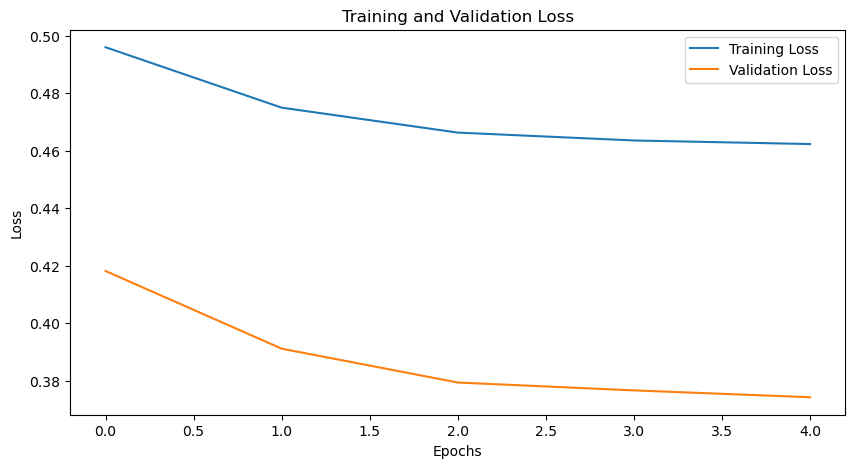

CPU times: user 4.02 s, sys: 131 ms, total: 4.16 s
Wall time: 3.32 s


In [94]:
%%time
# Initialize Model
# Update input_dim to include one-hot encoded permno_id length
input_dim = 128*5+1
model = TransformerModel(
    input_dim=input_dim,
    embed_dim=256,
    n_heads=16,
    ff_dim=1024,
    n_layers=6,
    output_dim=len(train_dataset.target_columns),
    dropout=0.25,
    attn_dropout=0.1,
    residual_dropout=0.1,
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training Loop
optimizer = torch.optim.RAdam(model.parameters(), lr=0.00005)
criterion = nn.L1Loss()
# criterion = nn.MSELoss()

train_losses = []
val_losses = []

num_epochs = 5
patience = 3
best_val_loss = float("inf")
patience_counter = 0

print("Starting Training...")
total_batches = num_epochs * len(train_dataloader)
total_start_time = time.time()

for epoch in range(num_epochs):
    start_time = time.time()  # Record the start time
    model.train()
    running_loss = 0.0
    batch_start_time = time.time()
    
    for i, batch in enumerate(train_dataloader):
        optimizer.zero_grad()
        output, _ = model(batch["features"].to(device))
        loss = criterion(output, batch["target"].to(device))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 20 == 0:
            # print(f"Batch {i}, Loss: {loss}, train_loss: {running_loss}")
            elapsed_time = time.time() - batch_start_time
            remaining_batches = len(train_dataloader) - (i + 1)
            estimated_remaining_time_epoch = remaining_batches * (elapsed_time / (i + 1))
            
            total_elapsed_time = time.time() - total_start_time
            total_remaining_batches = total_batches - ((epoch * len(train_dataloader)) + (i + 1))
            estimated_remaining_time_total = total_remaining_batches * (total_elapsed_time / ((epoch * len(train_dataloader)) + (i + 1)))

            print(f"Batch {i}/{len(train_dataloader)}, Loss: {loss:.4f}, "
                  f"Estimated time left for epoch: {time.strftime('%H:%M:%S', time.gmtime(estimated_remaining_time_epoch))}, "
                  f"Estimated time left for training: {time.strftime('%H:%M:%S', time.gmtime(estimated_remaining_time_total))}")
            
    train_losses.append(running_loss / len(train_dataloader))

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_dataloader:
            output, _ = model(batch["features"].to(device))
            loss = criterion(output, batch["target"].to(device))
            val_loss += loss.item()
    val_losses.append(val_loss / len(val_dataloader))

    epoch_time = time.time() - start_time  # Calculate the elapsed time
    print(f"Epoch {epoch+1}/{num_epochs} took {epoch_time:.2f} seconds")
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_losses[-1]}, Validation Loss: {val_losses[-1]}")

    if val_losses[-1] < best_val_loss:
        best_val_loss = val_losses[-1]
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

print("Training Complete")

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

#### Plot Prediction vs True Values (scaler.inverse_transform)

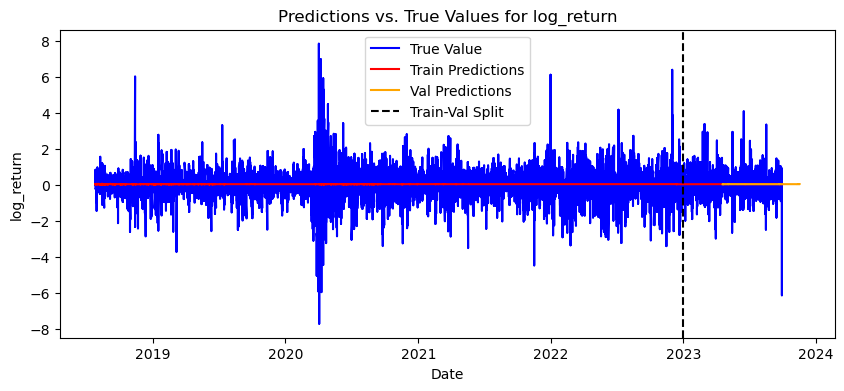

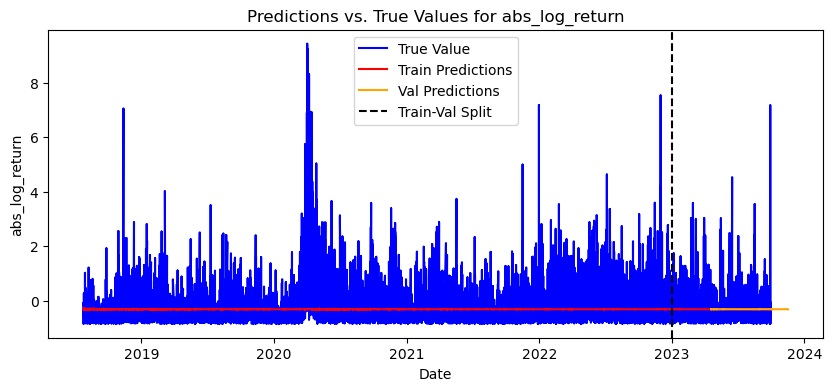

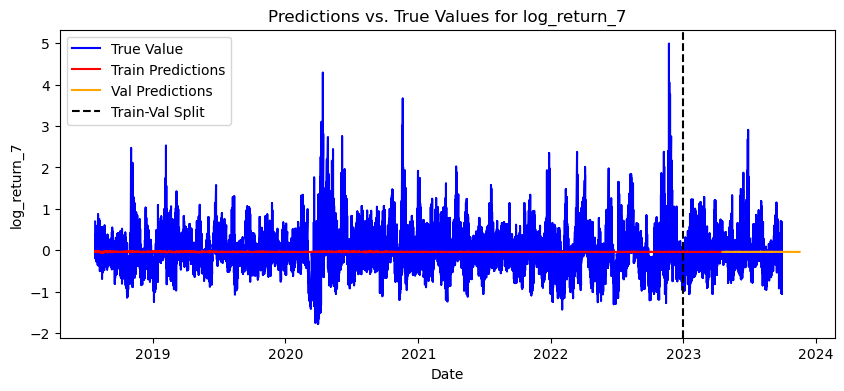

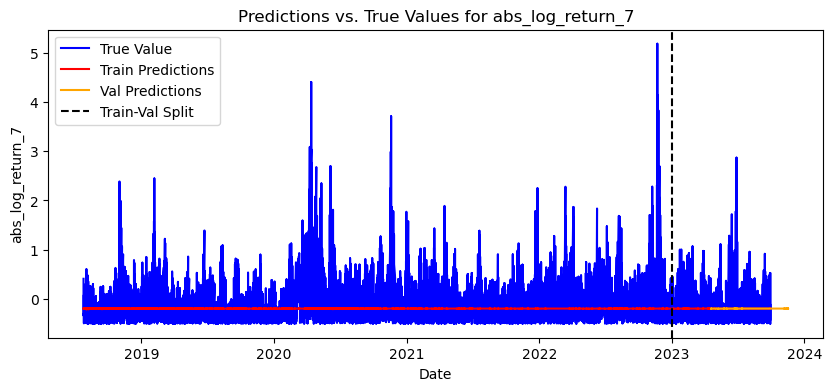

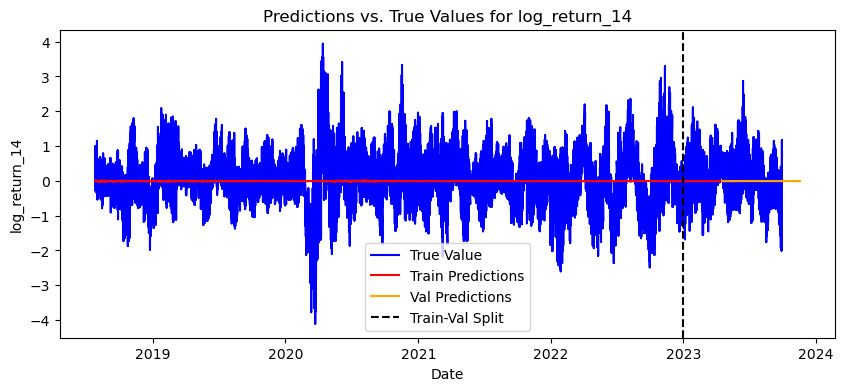

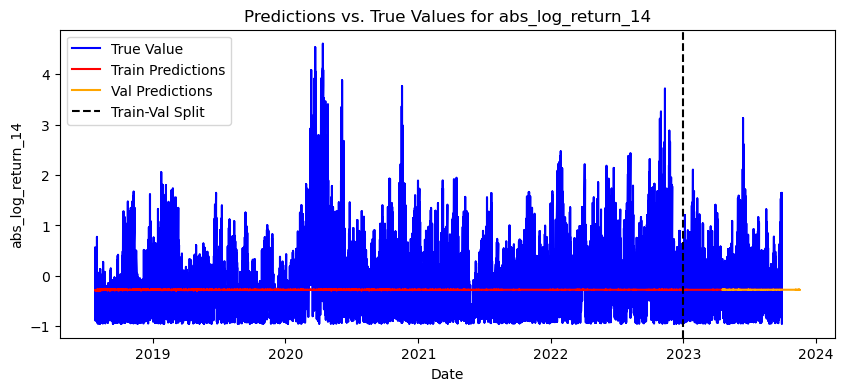

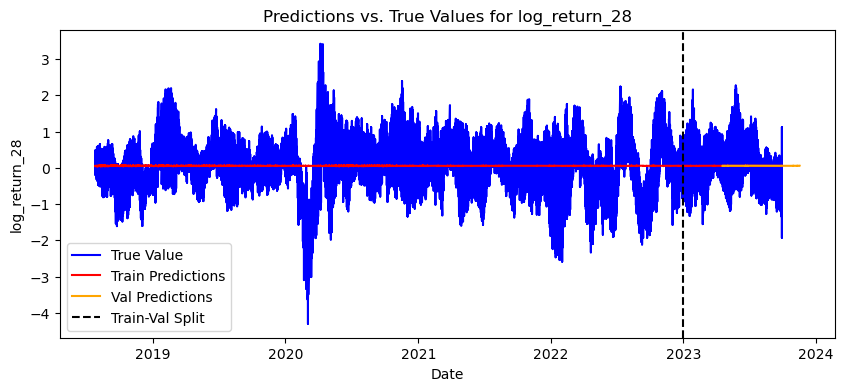

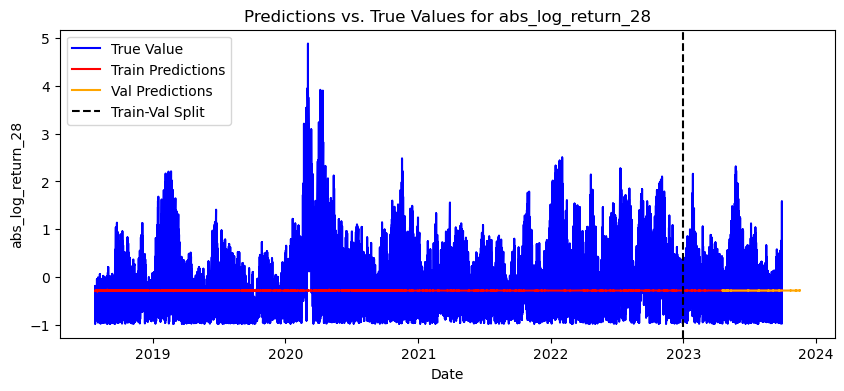

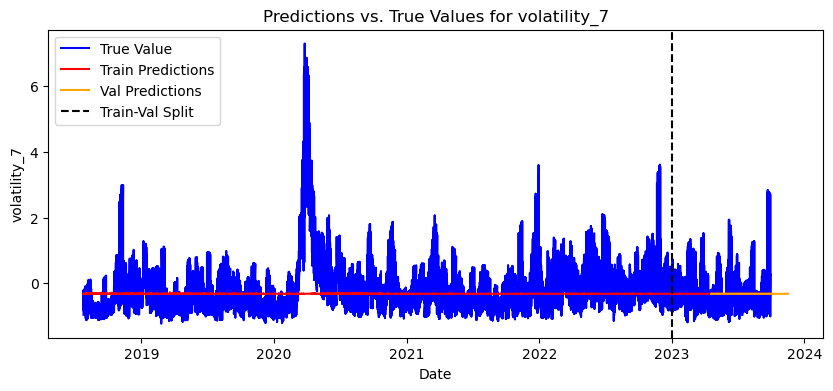

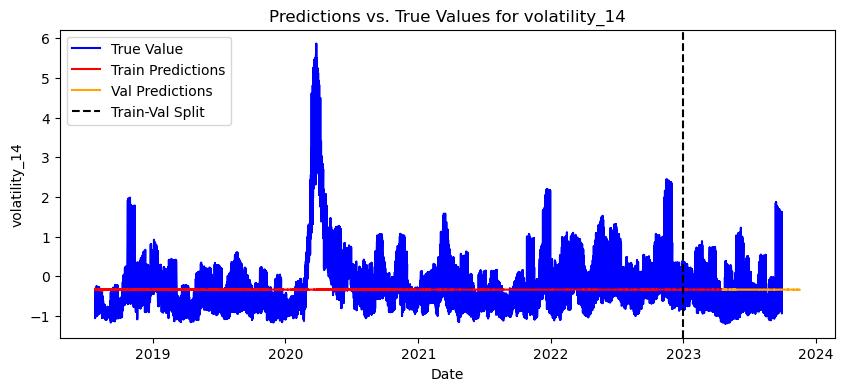

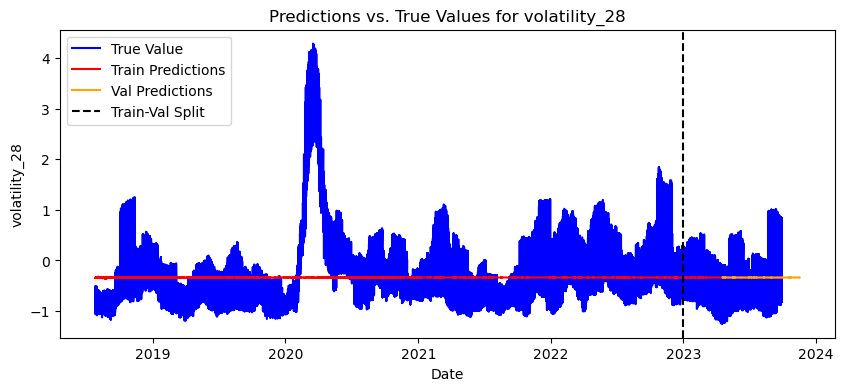

In [95]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from sklearn.preprocessing import StandardScaler

# Assuming the model and dataloaders are already defined and trained
# Also assuming the standardized_data is available

# Separate scaler for target columns
target_scaler = StandardScaler()
standardized_data[train_dataset.target_columns] = target_scaler.fit_transform(standardized_data[train_dataset.target_columns])

# Function to get predictions
def get_predictions(dataloader, model, device):
    model.eval()
    predictions = []
    true_values = []
    with torch.no_grad():
        for batch in dataloader:
            features = batch["features"].to(device)
            target = batch["target"].to(device)
            output, _ = model(features)
            predictions.append(output.cpu().numpy())
            true_values.append(target.cpu().numpy())
    return np.concatenate(predictions), np.concatenate(true_values)

# Get predictions for training and validation datasets
train_predictions, train_true_values = get_predictions(train_dataloader, model, device)
val_predictions, val_true_values = get_predictions(val_dataloader, model, device)

# Reshape predictions and true values to 2D arrays
train_predictions = train_predictions.reshape(-1, len(train_dataset.target_columns))
train_true_values = train_true_values.reshape(-1, len(train_dataset.target_columns))
val_predictions = val_predictions.reshape(-1, len(val_dataset.target_columns))
val_true_values = val_true_values.reshape(-1, len(val_dataset.target_columns))

# Inverse transform the predictions and true values using target_scaler
train_predictions = target_scaler.inverse_transform(train_predictions)
train_true_values = target_scaler.inverse_transform(train_true_values)
val_predictions = target_scaler.inverse_transform(val_predictions)
val_true_values = target_scaler.inverse_transform(val_true_values)

# Convert predictions and true values to DataFrame
train_predictions_df = pd.DataFrame(train_predictions, columns=train_dataset.target_columns)
train_true_values_df = pd.DataFrame(train_true_values, columns=train_dataset.target_columns)
val_predictions_df = pd.DataFrame(val_predictions, columns=val_dataset.target_columns)
val_true_values_df = pd.DataFrame(val_true_values, columns=val_dataset.target_columns)

# Ensure the date columns have matching lengths
train_dates = train_data.iloc[window_size:len(train_predictions) + window_size]['date'].values
if len(train_dates) < len(train_predictions_df):
    train_dates = np.append(train_dates, [train_dates[-1]] * (len(train_predictions_df) - len(train_dates)))
train_predictions_df['date'] = train_dates
train_true_values_df['date'] = train_dates

val_dates = validation_data.iloc[window_size:len(val_predictions) + window_size]['date'].values
if len(val_dates) < len(val_predictions_df):
    val_dates = np.append(val_dates, [val_dates[-1]] * (len(val_predictions_df) - len(val_dates)))
val_predictions_df['date'] = val_dates
val_true_values_df['date'] = val_dates

# Plotting function for each label
def plot_predictions_vs_true(label):
    plt.figure(figsize=(10, 4))

    # Plot the train data
    plt.plot(train_true_values_df['date'], train_true_values_df[label], label='True Value', color='blue')

    plt.plot(train_predictions_df['date'], train_predictions_df[label], label='Train Predictions', color='red')
    plt.plot(val_predictions_df['date'], val_predictions_df[label], label='Val Predictions', color='orange')

    plt.axvline(x=pd.to_datetime('2023-01-01'), color='black', linestyle='--', label='Train-Val Split')

    plt.xlabel('Date')
    plt.ylabel(label)
    plt.title(f'Predictions vs. True Values for {label}')
    plt.legend()
    plt.show()

# Plot for all labels
for label in train_dataset.target_columns:
    plot_predictions_vs_true(label)


#### Weights

In [96]:
input_embedding_weights = model.input_embedding.weight.detach().cpu().numpy()
print(input_embedding_weights)

[[-0.01484786 -0.02129708 -0.02268532 ...  0.00916821 -0.03174853
  -0.00891325]
 [ 0.01998838  0.03668599 -0.01457083 ... -0.00284817 -0.03517929
  -0.02394585]
 [-0.03610616  0.02764803 -0.01803069 ... -0.02072358  0.00165072
   0.0344052 ]
 ...
 [ 0.00268119  0.01388053  0.01191231 ... -0.03173269  0.02442878
  -0.03254788]
 [ 0.00679145 -0.03014337 -0.00886605 ... -0.00319954  0.03520552
  -0.02957246]
 [ 0.03453297  0.0186291  -0.02586539 ... -0.00164123 -0.03782102
  -0.02887785]]


In [97]:
input_embedding_weights.shape

(256, 641)

In [98]:
cosine_sim_matrix_input_embedding_weights = cosine_similarity(input_embedding_weights)
cosine_sim_matrix_input_embedding_weights

array([[ 0.99999994, -0.01581148,  0.01301279, ..., -0.04824625,
         0.04883183, -0.02284747],
       [-0.01581148,  1.0000001 ,  0.01099612, ..., -0.04885712,
         0.04171287,  0.0212431 ],
       [ 0.01301279,  0.01099612,  1.0000001 , ...,  0.02093498,
        -0.01152026, -0.05576327],
       ...,
       [-0.04824625, -0.04885712,  0.02093498, ...,  0.9999999 ,
        -0.02379625, -0.0035357 ],
       [ 0.04883183,  0.04171287, -0.01152026, ..., -0.02379625,
         1.        , -0.0184569 ],
       [-0.02284747,  0.0212431 , -0.05576327, ..., -0.0035357 ,
        -0.0184569 ,  1.0000002 ]], dtype=float32)

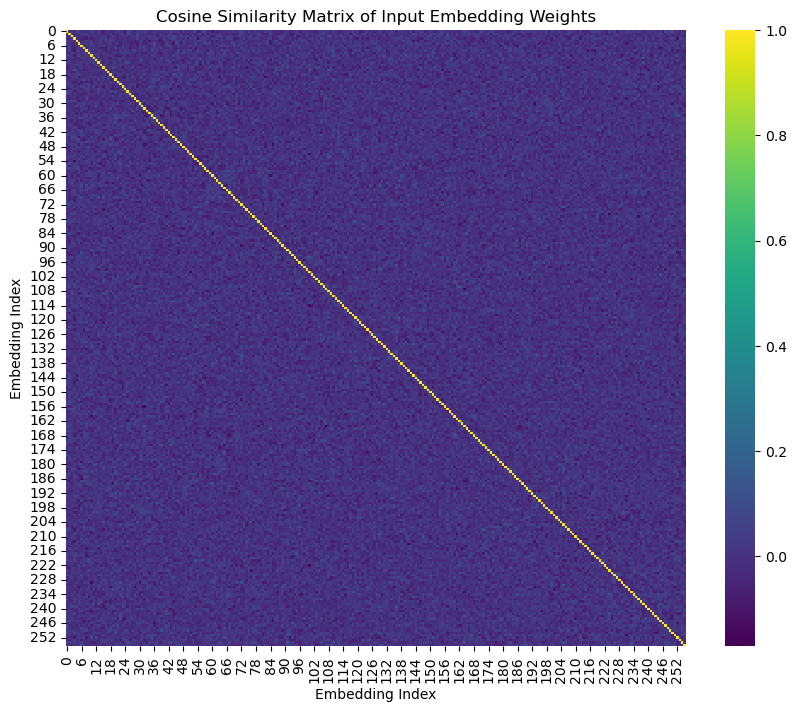

In [99]:
# Plot the cosine similarity matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cosine_sim_matrix_input_embedding_weights, annot=False, cmap='viridis')
plt.title('Cosine Similarity Matrix of Input Embedding Weights')
plt.xlabel('Embedding Index')
plt.ylabel('Embedding Index')
plt.show()

In [100]:
# To get the weights of the first encoder layer
encoder_layer_weights = model.transformer.layers[0].state_dict()
encoder_layer_weights

OrderedDict([('self_attn.in_proj_weight',
              tensor([[-0.0047,  0.0450, -0.0728,  ..., -0.0291,  0.0252, -0.0175],
                      [-0.0406,  0.0159, -0.0505,  ...,  0.0118,  0.0688,  0.0428],
                      [-0.0492, -0.0577,  0.0190,  ..., -0.0095, -0.0361,  0.0049],
                      ...,
                      [-0.0123,  0.0730, -0.0475,  ..., -0.0422,  0.0037,  0.0315],
                      [ 0.0391,  0.0053,  0.0563,  ...,  0.0442, -0.0384, -0.0438],
                      [ 0.0148, -0.0153, -0.0644,  ...,  0.0334,  0.0687, -0.0532]],
                     device='cuda:0')),
             ('self_attn.in_proj_bias',
              tensor([ 2.6976e-06, -2.2948e-04, -8.9615e-05,  2.4550e-04, -1.0949e-05,
                      -1.0063e-04, -4.9839e-05, -3.9021e-05,  4.3154e-05,  6.1657e-05,
                       3.5957e-05,  1.9605e-04,  4.0152e-05, -2.3108e-05, -3.7840e-04,
                       7.7417e-05, -1.5452e-04, -6.2664e-05,  3.1014e-05, -1.3637e-04

In [101]:
# If you want to get the weights of all encoder layers
all_encoder_layers_weights = [layer.state_dict() for layer in model.transformer.layers]
all_encoder_layers_weights

[OrderedDict([('self_attn.in_proj_weight',
               tensor([[-0.0047,  0.0450, -0.0728,  ..., -0.0291,  0.0252, -0.0175],
                       [-0.0406,  0.0159, -0.0505,  ...,  0.0118,  0.0688,  0.0428],
                       [-0.0492, -0.0577,  0.0190,  ..., -0.0095, -0.0361,  0.0049],
                       ...,
                       [-0.0123,  0.0730, -0.0475,  ..., -0.0422,  0.0037,  0.0315],
                       [ 0.0391,  0.0053,  0.0563,  ...,  0.0442, -0.0384, -0.0438],
                       [ 0.0148, -0.0153, -0.0644,  ...,  0.0334,  0.0687, -0.0532]],
                      device='cuda:0')),
              ('self_attn.in_proj_bias',
               tensor([ 2.6976e-06, -2.2948e-04, -8.9615e-05,  2.4550e-04, -1.0949e-05,
                       -1.0063e-04, -4.9839e-05, -3.9021e-05,  4.3154e-05,  6.1657e-05,
                        3.5957e-05,  1.9605e-04,  4.0152e-05, -2.3108e-05, -3.7840e-04,
                        7.7417e-05, -1.5452e-04, -6.2664e-05,  3.1014e-0

In [102]:
# Attention weights
attention_weights = encoder_layer_weights['self_attn.in_proj_weight']

# Feedforward weights
feedforward_weights = encoder_layer_weights['linear1.weight']

print("Attention Weights:", attention_weights.shape)
print("Feedforward Weights:", feedforward_weights.shape)


Attention Weights: torch.Size([768, 256])
Feedforward Weights: torch.Size([1024, 256])


In [78]:
# Initialize an empty tensor to accumulate the embeddings
accumulated_embeddings = torch.zeros(9, 256).to(device)
total_batches = 0

with torch.no_grad():
    for batch in train_dataloader:
        _, embeddings = model(batch["features"].to(device))
        #print(embeddings)
        accumulated_embeddings += embeddings.sum(dim=1)
        # total_batches += batch["features"].size(0)
        total_batches += embeddings.size(1)

# Divide the accumulated embeddings by the total number of batches to get the average
average_embeddings = accumulated_embeddings / total_batches
print(total_batches)
average_embeddings

1318


tensor([[ 1.1964, -1.5039,  0.9824,  ..., -0.9027,  0.5972,  1.1749],
        [ 1.1964, -1.5038,  0.9824,  ..., -0.9029,  0.5971,  1.1748],
        [ 1.1965, -1.5043,  0.9826,  ..., -0.9028,  0.5972,  1.1751],
        ...,
        [ 1.1964, -1.5041,  0.9826,  ..., -0.9029,  0.5972,  1.1750],
        [ 1.1964, -1.5040,  0.9826,  ..., -0.9031,  0.5970,  1.1750],
        [ 1.1965, -1.5041,  0.9825,  ..., -0.9028,  0.5973,  1.1750]],
       device='cuda:0')

In [79]:
accumulated_embeddings.shape

torch.Size([9, 256])

In [80]:
batch["features"].shape

torch.Size([6, 9, 641])

In [81]:
batch["features"].size(0)

6

#### Stock Embedding

In [83]:
%%time
# Extract embeddings for each stock
stock_embeddings = {}
model.eval()
with torch.no_grad():
    for batch in train_dataloader:
        _, embeddings = model(batch["features"].to(device))
        for i, permno_id in enumerate(batch["permno_id"]):
            if permno_id not in stock_embeddings:
                stock_embeddings[permno_id] = []
            stock_embeddings[permno_id].append(embeddings[i].cpu().numpy())

KeyError: 'permno_id'

In [54]:
%%time
# Average the embeddings for each stock
for permno_id in stock_embeddings:
    stock_embeddings[permno_id] = np.mean(stock_embeddings[permno_id], axis=0)

CPU times: user 3 μs, sys: 0 ns, total: 3 μs
Wall time: 7.15 μs


In [55]:
list(stock_embeddings.items())[:2]

[]

#### Cosine Similarity Matrix

In [56]:
%%time
# Assuming stock_embeddings is a dictionary with permno_id as keys and embeddings as values
embeddings_list = []
permno_ids = []

for permno_id, embedding in stock_embeddings.items():
    permno_ids.append(permno_id)
    embeddings_list.append(embedding)

# Convert the list of embeddings to a numpy array
embeddings_array = np.array(embeddings_list)

# Transform embeddings using cosine similarity
cosine_sim_matrix = cosine_similarity(embeddings_array)
cosine_sim_matrix

ValueError: Expected 2D array, got 1D array instead:
array=[].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.